In [1]:
!pip install "torch==1.4" "torchvision==0.5.0"

     |████████████████████████████████| 753.4MB 21kB/s 
     |████████████████████████████████| 4.0MB 47.4MB/s 
  Found existing installation: torch 1.7.0+cu101
    Uninstalling torch-1.7.0+cu101:
      Successfully uninstalled torch-1.7.0+cu101
  Found existing installation: torchvision 0.8.1+cu101
    Uninstalling torchvision-0.8.1+cu101:
      Successfully uninstalled torchvision-0.8.1+cu101


In [2]:
from fastai.vision import *

In [3]:
path = '/content/drive/My Drive/Colab Notebooks/Dataset_g'

In [4]:
np.random.seed(21)
data = ImageDataBunch.from_folder(path, train="Train", valid ="validations",
        ds_tfms=get_transforms(), size=(256,256), bs=32, num_workers=4).normalize()

In [5]:
data.classes, data.c, len(data.train_ds), len(data.valid_ds)

(['COVID', 'Normal', 'PNEUMONIA'], 3, 1347, 260)

In [6]:

print("Number of examples in training:", len(data.train_ds))
print("Number of examples in validation:", len(data.valid_ds))

Number of examples in training: 1347
Number of examples in validation: 260


In [7]:
xb,yb = data.one_batch()
xb.shape,yb.shape

(torch.Size([32, 3, 256, 256]), torch.Size([32]))

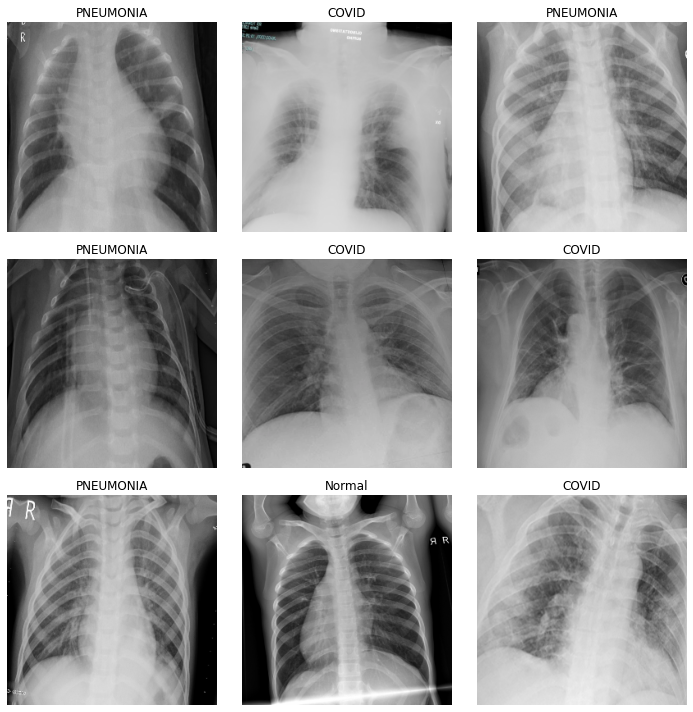

In [ ]:
data.show_batch(rows=3, figsize=(10,10))

In [8]:
def conv_block(ni, nf, size=3, stride=1):
    for_pad = lambda s: s if s > 2 else 3
    return nn.Sequential(
        nn.Conv2d(ni, nf, kernel_size=size, stride=stride,
                  padding=(for_pad(size) - 1)//2, bias=False), 
        nn.BatchNorm2d(nf),
        nn.LeakyReLU(negative_slope=0.1, inplace=True)  
    )

In [9]:

def triple_conv(ni, nf):
    return nn.Sequential(
        conv_block(ni, nf),
        conv_block(nf, ni, size=1),  
        conv_block(ni, nf)
    )

In [10]:
def maxpooling():
    return nn.MaxPool2d(2, stride=2)

In [11]:

model = nn.Sequential(
    conv_block(3, 8),
    maxpooling(),
    conv_block(8, 16),
    maxpooling(),
    triple_conv(16, 32),
    maxpooling(),
    triple_conv(32, 64),
    maxpooling(),
    triple_conv(64, 128),
    maxpooling(),
    triple_conv(128, 256),
    conv_block(256, 128, size=1),
    conv_block(128, 256),
    conv_block(256,512),
    conv_layer(512, 3),
    Flatten(),
    nn.Linear(507, 3)
)

In [12]:
learn = Learner(data, model, loss_func = nn.CrossEntropyLoss(), metrics=accuracy)#,root_mean_squared_error

In [13]:
print(learn.summary())

Sequential
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [8, 256, 256]        216        True      
______________________________________________________________________
BatchNorm2d          [8, 256, 256]        16         True      
______________________________________________________________________
LeakyReLU            [8, 256, 256]        0          False     
______________________________________________________________________
MaxPool2d            [8, 128, 128]        0          False     
______________________________________________________________________
Conv2d               [16, 128, 128]       1,152      True      
______________________________________________________________________
BatchNorm2d          [16, 128, 128]       32         True      
______________________________________________________________________
LeakyReLU            [16, 128, 128]       0          False     
___________________________________________________

In [14]:
learn.fit_one_cycle(40, max_lr=3e-3)

epoch,train_loss,valid_loss,accuracy,time
0,0.540291,0.785348,0.650000,04:39
1,0.387124,0.242547,0.892308,01:23
2,0.324630,0.219676,0.903846,01:23
3,0.305385,0.169644,0.911538,01:22
4,0.280357,0.285430,0.869231,01:22
5,0.281701,0.258136,0.888462,01:22
6,0.290188,0.138808,0.934615,01:22
7,0.283683,0.256797,0.915385,01:22
8,0.280825,0.330435,0.853846,01:23
9,0.294731,0.148003,0.950000,01:22


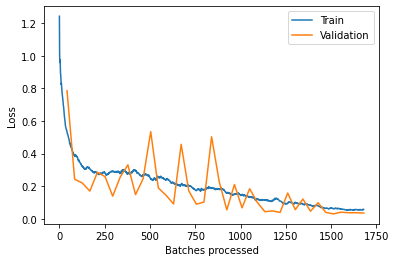

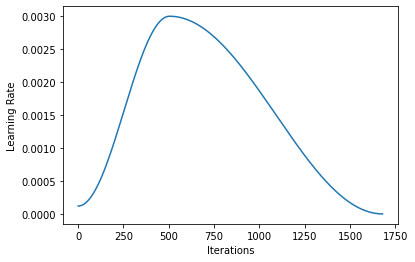

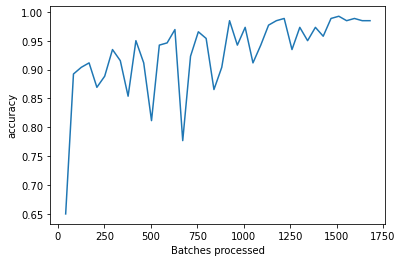

In [15]:
learn.recorder.plot_losses()
learn.recorder.plot_lr()
learn.recorder.plot_metrics()
#learn.recorder.plot_AUROC()
#learn.recorder.plot_root_mean_squared_error()

In [16]:
print("Number of examples in testing:", len(data.valid_ds))

Number of examples in testing: 260


In [17]:
probs,targets,loss = learn.get_preds(ds_type=DatasetType.Valid,with_loss=True) # prediction without data augmentation in test i.e. TTA 

In [18]:
accuracy(probs,targets)

tensor(0.9846)

In [19]:
probs = np.argmax(probs, axis=1)#, axis=1
correct = 0
for idx, pred in enumerate(probs):
    if pred == targets[idx]:
        correct += 1
accuracy = correct / len(probs)
print(len(probs), correct, accuracy)

from sklearn.metrics import confusion_matrix
np.set_printoptions(threshold=np.inf) # shows whole confusion matrix
cm1 = confusion_matrix(targets, probs)
print(cm1)

from sklearn.metrics import classification_report
y_true1 = targets
y_pred1 = probs
target_names = ['Covid-19', 'No_findings', 'Pneumonia']
print(classification_report(y_true1, y_pred1, target_names=target_names))

# from sklearn.metrics import mean_absolute_error
# mean_absolute_error(targets,probs)

260 256 0.9846153846153847
[[83  1  2]
 [ 0 87  1]
 [ 0  0 86]]
              precision    recall  f1-score   support

    Covid-19       1.00      0.97      0.98        86
 No_findings       0.99      0.99      0.99        88
   Pneumonia       0.97      1.00      0.98        86

    accuracy                           0.98       260
   macro avg       0.98      0.98      0.98       260
weighted avg       0.99      0.98      0.98       260



In [34]:
interp = ClassificationInterpretation.from_learner(learn)

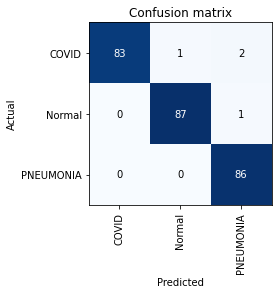

In [35]:
cm_fig = interp.plot_confusion_matrix(return_fig=True)
ax = cm_fig.gca()
ax.set_ylim(interp.data.c - .5, - .5);

In [ ]:
#learn.export('covidp.pkl')
learn.save('covidp')

In [36]:
from fastai.callbacks.hooks import *

In [57]:
learnn = load_learner('/content/drive/MyDrive/Colab Notebooks/Dataset_g')

In [58]:
# from sklearn.externals import joblib

# classifer = joblib.load("/content/drive/MyDrive/Colab Notebooks/Dataset_g/export.pkl")

In [59]:
model = learnn.model.eval()

In [60]:
img = open_image('/content/drive/MyDrive/Colab Notebooks/Dataset_g/teest/covid.jpeg')
img1 = open_image('/content/drive/MyDrive/Colab Notebooks/Dataset_g/teest/normal.jpeg')
img2 = open_image('/content/drive/MyDrive/Colab Notebooks/Dataset_g/teest/covid1.jpeg')
img3 = open_image('/content/drive/MyDrive/Colab Notebooks/Dataset_g/teest/pneumoniaa.png')
img4 =open_image('/content/drive/MyDrive/Colab Notebooks/Dataset_g/teest/pneumoia3.jpeg')

In [ ]:
# import cv2 
# img = cv2.imread('/content/drive/MyDrive/Colab Notebooks/Dataset_g/teest/')
# classifer.predict(img)
# import numpy as np
# from keras.preprocessing import image

# test_image = image.load_img('/content/drive/MyDrive/Colab Notebooks/Dataset_g/teest/covid.jpeg', target_size = (224, 224))
# test_image = image.img_to_array(test_image)
# test_image = np.expand_dims(test_image, axis = 0)
# result = classifer.predict(test_image)

In [ ]:
img

In [75]:
pred = learnn.predict(img3)
cls = int(pred[1])
pred,cls

((Category tensor(2), tensor(2), tensor([0.0156, 0.0046, 0.9798])), 2)

In [76]:
b,_ = learnn.data.one_item(img3)
img = Image(learnn.data.denorm(b)[0])

In [77]:
with hook_output(model[12]) as hook_a:  #output hooks is calculated then gradient of each is calculated out
  with hook_output(model[12], grad = True) as hook_g:
    preds = model(b)
    preds[0,cls].backward()

acts = hook_a.stored[0].cpu()
grad = hook_g.stored[0][0].cpu()

In [78]:
acts.shape

torch.Size([256, 13, 13])

In [79]:
grad.shape

torch.Size([256, 13, 13])

In [80]:
grad_chan = grad.mean(1).mean(1) #starndard technique i.e. avg gradient and add all to one
mult = ((acts * grad_chan[...,None, None])).sum(0)

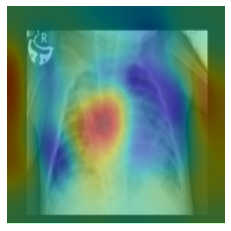

In [81]:
_, ax = plt.subplots()
img.show(ax)
ax.imshow(mult, alpha = 0.4, extent=(0,256,256,0), interpolation='bicubic', cmap='jet')

In [ ]:
# class LayerActivations():
#    features=[]
#    def __init__(self,model):
#        self.hooks = []
#        #model[12] is the last layer of our network before the Global Average Pooling layer(last convolutional layer).
#        self.hooks.append(model[12].register_forward_hook(self.hook_fn))
       
#    def hook_fn(self,module,input,output):
#        self.features.append(output)
       
#    def remove(self):
#        for hook in self.hooks:
#            hook.remove()

In [ ]:
# def predict_img(img, model_ft):
#   # image_path = path
#   # img = image_loader(image_path)
#   acts = LayerActivations(model_ft)
#   #img = img.cpu()
#   logps = model_ft(img)
#   ps = torch.exp(logps) 
#   out_features = acts.features[0]
#   out_features = torch.squeeze(out_features, dim=0)
#   out_features = np.transpose(out_features.cpu(),axes=(1,2,0))
#   W = model_ft.fc[0].weight
#   top_probs, top_classes = torch.topk(ps, k=2)
#   pred = np.argmax(ps.detach().cpu())
#   w = W[pred,:]
#   cam = np.dot(out_features.cpu(), w.detach().cpu())
#   class_activation = nd.zoom(cam, zoom=(32,32),order=1)
#   img = img.cpu()
#   img = torch.squeeze(img,0)
#   img = np.transpose(img,(1,2,0))
#   mean = np.array([0.5,0.5,0.5])
#   std =  np.array([0.5,0.5,0.5])
#   img = img.numpy()
#   img = (img + mean) * std
#   img = np.clip(img, a_max=1, a_min=0)
#   return img, class_activation, pred

In [ ]:
# #test_dir='/Test_Set/'
# from skimage.io import imread
# from PIL import Image
# import glob
# #image_list = []
# # for filename in glob.glob(test_dir+'/*.jpeg'): 
# #     #im=Image.open(filename)
# #     image_list.append(filename)

# #f, ax = plt.subplots(4,4, figsize=(30,10))

# def predict_image(image, model_ft):
#   img, class_activation, pred = predict_img(image, model_ft)
#   print(pred.item())
#   # name = image.split("/")
#   # name = name[len(name)-1].split(".")[0]
#   img = Image.fromarray((img * 255).astype(np.uint8))
#   plt.ioff()
#   plt.imshow(class_activation, cmap='jet',alpha=1)
#   plt.imshow(img, alpha=0.55)
#   plt.title(dset['test'].classes[pred])
#   plt.tight_layout()

#   # plt.show()
#   return pred

# predict_image(img, model)

In [ ]:
#!pip list

In [ ]:
# from sklearn.metrics import roc_curve,auc
# fpr, tpr, thresholds = roc_curve(targets, probs, pos_label=1)

# roc_auc = auc(fpr, tpr)
# print('ROC area is {0}'.format(roc_auc))

# plt.figure()
# plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.2f)' % roc_auc)
# plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
# plt.xlim([-0.01, 1.0])
# plt.ylim([0.0, 1.01])
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('Receiver operating characteristic')
# plt.legend(loc="upper left")